In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)
X_dev = torch.from_numpy(X_dev)
y_dev = torch.from_numpy(y_dev)

## Softmax 分类器

In [5]:
from cs231n.classifiers.softmax import softmax_loss_vectorized_pytorch

# 初始化W
W = torch.randn(3073, 10).double() * 0.0001
loss, grad = softmax_loss_vectorized_pytorch(W, X_dev, y_dev, 0.0)

print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.311753
sanity check: 2.302585


In [6]:
# 使用验证集来调整超参(正则化强度和学习率)。你应该尝试不同的学习率和正则强度
# 如果谨慎的话，你应该能够在验证集上获得超过0.35的分类准确度
from cs231n.classifiers import Softmax_pytorch
results = {}
best_val = -1
best_softmax = None
learning_rates = [4.9e-7, 5e-7, 5.1e-7]
regularization_strengths = [1.4e4, 1.5e4, 1.6e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        sm = Softmax_pytorch()
        sm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=2000)
        train_pred = sm.predict(X_train)
        train_accuracy = (train_pred == y_train).double().mean()
        val_pred = sm.predict(X_val)
        val_accuracy = (val_pred == y_val).double().mean()
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = sm
        
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 4.900000e-07 reg 1.400000e+04 train accuracy: 0.345000 val accuracy: 0.362000
lr 4.900000e-07 reg 1.500000e+04 train accuracy: 0.345755 val accuracy: 0.356000
lr 4.900000e-07 reg 1.600000e+04 train accuracy: 0.345796 val accuracy: 0.355000
lr 5.000000e-07 reg 1.400000e+04 train accuracy: 0.339163 val accuracy: 0.351000
lr 5.000000e-07 reg 1.500000e+04 train accuracy: 0.338388 val accuracy: 0.359000
lr 5.000000e-07 reg 1.600000e+04 train accuracy: 0.331408 val accuracy: 0.354000
lr 5.100000e-07 reg 1.400000e+04 train accuracy: 0.339408 val accuracy: 0.361000
lr 5.100000e-07 reg 1.500000e+04 train accuracy: 0.338347 val accuracy: 0.355000
lr 5.100000e-07 reg 1.600000e+04 train accuracy: 0.341020 val accuracy: 0.352000
best validation accuracy achieved during cross-validation: 0.362000


## 在测试集上使用最佳模型

In [9]:
y_test_pred = best_softmax.predict(X_test)
test_accuracy = (y_test == y_test_pred).double().mean()
print('softmax on raw pixels final test set accuracy: %f' % test_accuracy)

softmax on raw pixels final test set accuracy: 0.355000


## 可视化每个类的权重

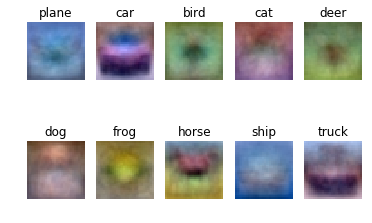

In [11]:
w = best_softmax.W[:-1, :] # 跳过偏置
w = w.reshape(32, 32, 3, 10)
w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    plt.subplot(2, 5, i+1)
    
    # 调整权重到 [0, 255]
    wimg = 255.0 * (w[:, :, :, i] - w_min) / (w_max - w_min)
    plt.imshow(wimg.numpy().astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

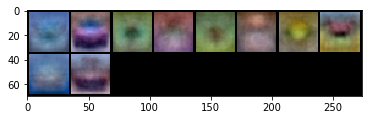

In [18]:
w = best_softmax.W[:-1, :] # 跳过偏置
w = torch.from_numpy(w.reshape(32, 32, 3, 10).numpy().transpose(3, 2, 0, 1))

plt.imshow(torchvision.utils.make_grid(w, normalize=True).numpy().transpose(1, 2, 0))